Implementation of a DAODEN_full in "Variational Deep Learning for the Identification and Reconstruction of Chaotic and Stochastic Dynamical Systems from Noisy and Partial Observations", (https://arxiv.org/abs/2009.02296)

## Config

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.distributions as tdist
import pickle
import sys
import os
import scipy
from scipy.stats import multivariate_normal
from tqdm import tqdm
import time

import models
import logging
import log_manager
from daoden_datasets import DAODEN_Dataset
import daoden_utils

mse_loss = torch.nn.MSELoss()
l1_loss  = torch.nn.L1Loss()

if 1:
    device=torch.device("cpu")
else:
    device=torch.device("cuda:0")

manual_seed = 58
torch.manual_seed(manual_seed)
np.random.seed(manual_seed)
    
class Config():

    ## Data flags
    normalize_data    = True
    noise_ratio       = 0.33
    dt_integration    = 0.01
    dt_obs            = 0.00 # dt_obs == 0.0: the observation is partial
    segment_len       = 150
    init_seg_len      = 23 # used for the Auxiliary Net
    
    dataset_dir       = "./datasets/L63-r-%s_att"%str(noise_ratio)

    ## Model flags
    n_samples         = 1 # for IWAE
    n_step_ahead_max  = 4 
    obs_dim           = 3 
    state_dim         = 3 
    rnn_size          = 9 
    fc_hidden_size    = 7
    fc_n_layers       = 1 
    encoded_data_size = 3
    keep_prob         = 1

    # For DAODEN_full and DAODEN_MAP
    std_q_min       = 0.005
    std_prior_min   = 0.005
    std_p           = 0.4
    
    raw_var_bias    = 0.01
    
    # For DAODEN_determ
    trans_w         = 1
    obs_w           = 0.01

    ## Training flags
    batch_size         = 4
    trained_model_dir  = ""
    trained_epoch      = 1001
    pretrained         = True
    retrain            = True
    
    opt_type           = "RMSprop"
    lr_rinn            = 1e-3
    lr_inf             = 1e-3
    weight_decay       = 0.0
    grad_clipping_value  = 1.0 

    n_epochs           = 1001
    scheduler_step     = 500
    scheduler_gamma    = 0.1
    scheduler_max_step = 1000
    log_freq           = 5
    save_freq          = 10
    
    model_name = "daoden_full"
    if model_name in ["daoden_determ","daoden_MAP"]:
        n_samples = 1

    savedir = "./"+model_name+"/"
    filename = "dt_obs-"+str(dt_obs)\
                +"-seg_len-"+str(segment_len)+"-"+str(init_seg_len)\
                +"-bs-"+str(batch_size)\
                +"-n_samples-"+str(n_samples)\
                +"-nsh-"+str(n_step_ahead_max)\
                +"-lr-{0:.0e}-{1:.0e}".format(lr_rinn,lr_inf)\
                +"-gcl-"+str(grad_clipping_value)\
                +"-scheduler-{0:.2f}-{1:d}-{2:d}".format(scheduler_gamma,scheduler_step,scheduler_max_step)
    if (model_name == "daoden_determ"):
        filename = filename + "-loss_weights-"+str(trans_w)+"_"+str(obs_w)
    else:
        filename = filename +"-std_min-"+str(std_q_min)+"_"+str(std_prior_min)+"_"+str(std_p)\
    
    filename = filename + "-n_epochs-"+str(n_epochs)+"-"+os.path.basename(dataset_dir)

    logdir = os.path.join(savedir,filename)

config = Config()

Create log

In [2]:
print(config.filename)
print(config.logdir)

if os.path.isdir(config.logdir) == 0:
    os.makedirs(config.logdir)
    print('======= Create directory to store trained models: '+config.logdir)
else:
    print('======= Directory to store trained models: '+config.logdir)

log_manager.new_log(config.logdir,config.filename)

dt_obs-0.0-seg_len-150-23-bs-4-n_samples-1-nsh-4-lr-1e-03-1e-03-gcl-1.0-scheduler-0.10-500-1000-std_min-0.005_0.005_0.4-n_epochs-1001-L63-r-0.33_att
./daoden_full/dt_obs-0.0-seg_len-150-23-bs-4-n_samples-1-nsh-4-lr-1e-03-1e-03-gcl-1.0-scheduler-0.10-500-1000-std_min-0.005_0.005_0.4-n_epochs-1001-L63-r-0.33_att
======= Directory to store trained models: ./daoden_full/dt_obs-0.0-seg_len-150-23-bs-4-n_samples-1-nsh-4-lr-1e-03-1e-03-gcl-1.0-scheduler-0.10-500-1000-std_min-0.005_0.005_0.4-n_epochs-1001-L63-r-0.33_att


## Data loading and processing

#### Dataset


In [3]:
seqs_train = np.load(os.path.join(config.dataset_dir,"seqs_train.npy")).astype(np.float32)
obs_train = np.load(os.path.join(config.dataset_dir,"obs_train.npy")).astype(np.float32)
masks_train = np.load(os.path.join(config.dataset_dir,"masks_train.npy")).astype(np.float32)
seqs_valid = np.load(os.path.join(config.dataset_dir,"seqs_valid.npy")).astype(np.float32)
obs_valid = np.load(os.path.join(config.dataset_dir,"obs_valid.npy")).astype(np.float32)
masks_valid = np.load(os.path.join(config.dataset_dir,"masks_valid.npy")).astype(np.float32)
seqs_test = np.load(os.path.join(config.dataset_dir,"seqs_test.npy")).astype(np.float32)
obs_test = np.load(os.path.join(config.dataset_dir,"obs_test.npy")).astype(np.float32)
masks_test = np.load(os.path.join(config.dataset_dir,"masks_test.npy")).astype(np.float32)
v_mean = daoden_utils.L63_MEAN
v_std  = daoden_utils.L63_STD
v_x_axis = np.arange(config.segment_len-config.init_seg_len-config.n_step_ahead_max-config.init_seg_len)
if not config.normalize_data:
    v_mean = np.zeros(v_mean.shape)
    v_std  = np.ones(v_std.shape)

Pytorch dataset

In [4]:
dataset_train   = DAODEN_Dataset(config, obs_train, seqs_train, masks_train, v_mean, v_std)
dataset_valid   = DAODEN_Dataset(config, obs_valid, seqs_valid, masks_valid, v_mean, v_std)
dataset_test   = DAODEN_Dataset(config, obs_test, seqs_test, masks_test, v_mean, v_std)

In [5]:
inputs, targets, masks, clean_targets = dataset_train[0]

In [6]:
print(inputs.shape, inputs.dtype)
print(clean_targets.shape)

(150, 3) float32
(150, 3)


Data loader

In [7]:
dl_train = DataLoader(dataset_train, batch_size=config.batch_size,shuffle=True, num_workers=8)
dl_valid = DataLoader(dataset_valid, batch_size=50,shuffle=False, num_workers=8)
dl_test = DataLoader(dataset_test, batch_size=50,shuffle=False, num_workers=8)

In [8]:
dl = {"train": dl_train,
      "valid": dl_valid,
      "test" : dl_test}

In [9]:
inputs, targets, masks, clean_targets = iter(dl["train"]).next()

In [10]:
print(inputs.shape, inputs.dtype)
print(clean_targets.shape)

torch.Size([4, 150, 3]) torch.float32
torch.Size([4, 150, 3])


## Models 

#### Trainsition model

In [11]:
### BiNN NET
binn_cell = models.BiNN(config.obs_dim,config.obs_dim,config.state_dim,3,1,device=device)
trans_model = models.RK4_Net(binn_cell,config.dt_integration,device=device)

l_fcnet_hidden_sizes = [config.fc_hidden_size]*config.fc_n_layers
var_prior_decoder = models.MLP([2*config.state_dim]+l_fcnet_hidden_sizes+[config.state_dim]).to(device)

#### Inference model

In [12]:
## AUXILIARY NETS
init_obs_encoder   = models.MLP([config.obs_dim]+l_fcnet_hidden_sizes+[config.encoded_data_size]).to(device)
init_state_decoder = models.MLP([config.rnn_size]+l_fcnet_hidden_sizes+[2*config.state_dim]).to(device) #mu, std
init_lstm_f          = nn.LSTM(config.encoded_data_size, config.rnn_size).to(device)
init_lstm_b          = nn.LSTM(config.encoded_data_size, config.rnn_size).to(device)


## INFERENCE NET
obs_encoder  = models.MLP([config.obs_dim]+l_fcnet_hidden_sizes+[config.encoded_data_size]).to(device)
mu_q_encoder = models.MLP([config.state_dim]+l_fcnet_hidden_sizes+[config.encoded_data_size]).to(device)
bias_and_var_q_decoder = models.MLP([2*config.rnn_size+config.encoded_data_size]+l_fcnet_hidden_sizes+[2*config.state_dim]).to(device)

lstm_f = nn.LSTM(config.encoded_data_size, config.rnn_size).to(device)
lstm_b = nn.LSTM(config.encoded_data_size+config.rnn_size, config.rnn_size).to(device)

#### Generative model

In [13]:
#var_p_decoder = models.MLP([config.rnn_size+2*config.state_dim]+l_fcnet_hidden_sizes+[config.obs_dim]).to(device)

### DaODEN

In [14]:
#===================================================================================
class DAODEN(nn.Module):
    """ Implementation of DAODEN
    https://arxiv.org/abs/2009.02296
    """
    def __init__(self, trans_model, var_prior_decoder,
                 lstm_f, lstm_b, obs_encoder, bias_and_var_q_decoder,
                 init_state_encoder, init_state_decoder, init_lstm_f, init_lstm_b,            
                 n_samples,
                 state_dim,
                 model_name           = "",
                 std_p                = 0.01,
                 init_seg_len         = 24,
                 std_prior_min        = 0.005,
                 std_q_min            = 0.005,
                 raw_var_bias         = 0.25,
                 device               = device
                ):
        """ Create a DAODEN cell.
        Args:
            trans_model: the transition function F: z_{k+1} = F(z_k).
            var_prior_decoder: a callable that take (z_t and F^n(z_t)) as input to 
                estimate the diag of the model error covariance matrix. 
            lstm_f, lstm_b: the forward and backward LSTM of the inference model.
            obs_encoder: a callable that "encodes" the observations. Must accept as
                argument the observations z_k (batch_size,obs_dim) and return a 
                tensor of shape (batch_size,encoded_data_size).
            bias_and_var_q_decoder: a callable that estimates the bias and the diag
                of the covariance matrix of the appromixated inference distribution.
                Must accept as argument [mu_prior_encoded, rnn_f_state, rnn_b_state]
                and return a tensor of shape (batch_size,2*state_dim).
            init_state_encoder, init_state_decoder: similar to obs_encoder.
            init_lstm_f, init_lstm_b: similar to lstm_f, lstm_b.
            model_name:
            std_p: estimated std of the emission distribution.
            init_seg_len: lenth of the segments that are used by the Auxiliary Nets.
            std_prior_min:
            std_q_min:
            raw_var_bias:
        
        """
        super(DAODEN, self).__init__()
        
        
        self.device = device
        self.model_name = model_name
        
        self.dt_integration       = trans_model.dt_integration
        self.state_dim            = state_dim
        self.n_samples            = n_samples
        
        self.init_obs_encoder   = init_obs_encoder
        self.init_state_decoder = init_state_decoder
        self.init_lstm_f          = init_lstm_f
        self.init_lstm_b          = init_lstm_b
        self.init_seg_len       = init_seg_len
        
        self.obs_encoder   = obs_encoder
        self.bias_and_var_q_decoder = bias_and_var_q_decoder
        self.var_prior_decoder = var_prior_decoder
        
        self.mu_q_encoder = mu_q_encoder
        
        self.lstm_f         = lstm_f
        self.lstm_b         = lstm_b
        self.trans_model    = trans_model

        self.var_p              = torch.tensor(std_p**2).to(device)
        self.std_p              = torch.tensor(std_p).to(device)
        self.var_prior_min      = torch.tensor(std_prior_min**2).to(device)
        self.var_q_min          = torch.tensor(std_q_min**2).to(device)
        
        self.raw_var_bias = raw_var_bias
        
    def rnn_zero_state(self, batch_size, rnn_size):
        return (torch.zeros(1, batch_size, rnn_size).to(self.device),
                torch.zeros(1, batch_size, rnn_size).to(self.device))

    #=============================================================================
    def set_observations(self, input_seq, target_seq, clean_target_seq = None):
        """Process the observations (inputs, targets) for the MCMC step, inclusing:
        running the auxiliary nets to estimate h_0, z_0, h_T; encoding the observations. 

        Args:
            input_seq: a batch of input sequences represented as a tensor of shape 
                [seq_len,batch_size,data_dim]. This is the obsersed sequences shifted
                one timestep into the past, padded with zeros.
            target_seq: the observed sequences, shape = [seq_len,batch_size,data_dim].
            clean_target_seq: the correspoding sequences of the true states of target_seq.             
        """
        
        full_seq_len,batch_size,obs_dim = input_seq.shape
        seq_len = full_seq_len - 2*self.init_seg_len
        if self.init_seg_len == 0:
            inf_input_seq = input_seq
            self.inf_target_seq  = target_seq
            self.inf_clean_target_seq  = clean_target_seq
            self.mu_and_var_q_init_seq = torch.cat([inf_input_seq[:1, :, :], 
                                                    self.var_q_min*torch.ones(1, batch_size, obs_dim).to(self.device)], 2)
            init_rnn_f_state_final = self.rnn_zero_state(batch_size,self.lstm_f.hidden_size)
            init_rnn_b_state_final = self.rnn_zero_state(batch_size,self.lstm_f.hidden_size)
        else:      
            
            # The first part of the seq is for the AUXILIARY_NET, the second part is for the INF_NET
            init_input_f_seq = target_seq[:self.init_seg_len,:,:]
            init_input_b_seq = target_seq[-self.init_seg_len:,:,:]
            buffer_input_seq = target_seq[self.init_seg_len:self.init_seg_len+1,:,:]
            inf_input_seq   = input_seq[self.init_seg_len:-self.init_seg_len,:,:]
            self.inf_target_seq  = target_seq[self.init_seg_len:-self.init_seg_len,:,:]
            
            ## AUXILIARY_NET estimates the initial dynamics state and the initial lstm state for the INF_NET
            #=============================================================================
            init_rnn_f_state       = self.rnn_zero_state(batch_size,self.lstm_f.hidden_size)
            init_rnn_b_state       = self.rnn_zero_state(batch_size,self.lstm_b.hidden_size)
            rev_init_input_seq_b      = models.reverse_sequence(init_input_b_seq, seq_axis=0, device=device)

            init_input_f_encoded       = models.encode_all(init_input_f_seq, self.init_obs_encoder)
            rev_init_input_b_encoded   = models.encode_all(rev_init_input_seq_b, self.init_obs_encoder)
            buffer_input_encoded       = models.encode_all(buffer_input_seq, self.init_obs_encoder) 

            # Init_RNN
            # [seq_len,batch_size,rnn_size]
            init_rnn_f_state_seq, init_rnn_f_state_final = self.init_lstm_f(init_input_f_encoded,init_rnn_f_state)
            init_rnn_b_state_seq, init_rnn_b_state_final = self.init_lstm_b(rev_init_input_b_encoded,init_rnn_b_state)

            # Init states
            buffer_rnn_state_seq, buffer_state_final = self.init_lstm_f(buffer_input_encoded,init_rnn_f_state_final)
            self.mu_and_var_q_init_seq = models.encode_all(buffer_rnn_state_seq,self.init_state_decoder)
        
        ## INF_NET
        #=============================================================================
        
        # Encode
        inf_input_seq_encoded  = models.encode_all(inf_input_seq, obs_encoder)# [seq_len,batch_size,encoded_data_size]
        inf_target_seq_encoded = models.encode_all(self.inf_target_seq,obs_encoder)
        
        # Initialize the rnns' state and the system's state
        rnn_f_state = init_rnn_f_state_final
        rnn_b_state = init_rnn_b_state_final
        
        # RNN forward
        self.rnn_f_state_seq,_ = self.lstm_f(inf_input_seq_encoded,rnn_f_state) # [seq_len,batch_size,rnn_size]
        # RNN backward
        target_and_rnn_f_state_seq = torch.cat([self.rnn_f_state_seq, inf_target_seq_encoded], 2)
        rev_target_and_rnn_f_state_seq = models.reverse_sequence(target_and_rnn_f_state_seq, seq_axis=0, device=device)
        rev_rnn_b_state_seq, _ = self.lstm_b(rev_target_and_rnn_f_state_seq,rnn_b_state)
        
        self.rnn_b_state_seq = models.reverse_sequence(rev_rnn_b_state_seq, seq_axis=0, device=device)

    #=============================================================================
    def transition(self, z_q, n_step_ahead = 1):
        """Calculate the transition distribution p(z_{k+n}|z_k).
        Args:
            z_q: the states sampled from the approximate posterior distribution q.
            n_step_ahead
        Returns:
            z_prior: the forcasted states.
            var_prior: the diagonal of the model error covariance matrix.
        """
        # Forecast the states
        z_prior = z_q+0
        for d_n_step in range(n_step_ahead):
            z_prior, _ = self.trans_model(z_prior, self.dt_integration)
            
        # Estimate the variance
        if self.model_name in ["daoden_MAP","daoden_full"]:
            var_prior   = self.var_prior_decoder(torch.cat([z_prior,
                                                            z_q],1),) # [batch_size,state_dim])
            var_prior   = torch.max(self.var_prior_min, F.softplus(var_prior+self.raw_var_bias))#[seq_len,bs,data_dim]
            return z_prior, var_prior
        else:
            return z_prior, torch.zeros(z_prior.shape)    
    #=============================================================================    
    def inference(self, mu_prior,rnn_f_state,rnn_b_state):
        """Calculate the approximate posterior distribution q(z_{k+n}|x_{0:T}).
        Args:
            mu_prior: the  mean of the prior (transition) distribution p(z_{k+n}|z_k).
            rnn_f_state, rnn_b_state: the states of the forward and backward LSTM at
                timestep k=n.
        Returns:
            mu_q: the mean of  q(z_{k+n}|x_{0:T}).
            var_q: the diagonal of q(z_{k+n}|x_{0:T}).
        """
        mu_prior_encoded = self.mu_q_encoder(mu_prior)
        bias_and_var_q = self.bias_and_var_q_decoder(torch.cat([mu_prior_encoded,
                                                        rnn_f_state,
                                                        rnn_b_state],1)
                                                    ) # [batch_size,state_dim]
        bias_q, var_q  = torch.chunk(bias_and_var_q,2,dim=-1)
        mu_q           = mu_prior + bias_q  
        var_q          = torch.max(self.var_q_min, 
                           F.softplus(var_q+self.raw_var_bias))#[seq_len,bs,data_dim]
        return mu_prior + bias_q, var_q
    
    #=============================================================================
#     def emission(self, mu_q,var_q,rnn_f_state):
#         mu_q_encoded  = self.mu_q_encoder(mu_q)
#         var_q_encoded = self.var_q_encoder(var_q)
        
#         var_p   = self.var_p_decoder(torch.cat([mu_q_encoded,
#                                                 var_q_encoded,
#                                                 rnn_f_state],1)) # [batch_size,state_dim])
#         var_p   = torch.max(self.var_p_min, F.softplus(var_p+self.raw_var_bias))#[seq_len,bs,data_dim]
#         return var_p    


    #=============================================================================
    def sequence(self,t_idx,n_step_ahead):
        """Compute one timestep of the MCMC.
        Args:
            t_idx: timestep
            n_step_ahead
        Returns:
            mu_prior,var_prior: the mean and the diagonal of the covariance matrix 
                of  p(z_{k+n}|z_k).
            mu_q,var_q: the mean and the diagonal of the covariance matrix of
                q(z_{k+n}|x_{0:T}).
            z_q: the states sampled from q(z_{k+n}|x_{0:T}).
            var_p: the diagonal of the covariance matrix of p(x_{k+n}|z_{k+n}}).
        """
        ## DYNAMIC
        #========================================
        z_q_prev = self.z_q_seq[t_idx].clone() #[batch_size*n_samples,state_dim]
        # particle 1 of filter 1 
        # particle 1 of filter 2 
        # ...
        # particle n of filter 1 
        # particle n of filter 2

        mu_prior,var_prior = self.transition(z_q_prev,n_step_ahead)
        if self.model_name in ["daoden_MAP","daoden_full"]:
            prior_dist = tdist.MultivariateNormal(mu_prior,
                                                  covariance_matrix=torch.diag_embed(var_prior))

        ## INFERENCE
        #========================================
        mu_q,var_q = self.inference(mu_prior,
                                    self.rnn_f_state_seq[t_idx+n_step_ahead,:,:].repeat((self.n_samples,1)),
                                    self.rnn_b_state_seq[t_idx+n_step_ahead,:,:].repeat((self.n_samples,1))
                                   )
        if self.model_name in ["daoden_full"]:
            q_dist         = tdist.MultivariateNormal(mu_q,
                                                      covariance_matrix=torch.diag_embed(var_q))
            z_q            = q_dist.rsample() #[batch_size*n_sample,state_dim]
        else:
            z_q = mu_q
        

        ## GENERATIVE
        #========================================  
        if self.model_name in ["daoden_MAP","daoden_full"]:
            var_p = torch.ones(z_q.shape).to(self.device)*self.var_p
            std_p = torch.ones(z_q.shape).to(self.device)*self.std_p
        elif self.model_name == "daoden_determ":
            var_p = torch.zeros(z_q.shape).to(self.device)
        
        return mu_prior,var_prior,mu_q,var_q,z_q,var_p

    #=============================================================================
    #=============================================================================
    def forward(self, input_seq, target_seq, mask_seq, clean_target_seq = None, n_step_ahead = 4, return_states = False):
        """Run DAODEN

        Args:
            input_seq: a batch of input sequences represented as a tensor of shape 
                [seq_len,batch_size,data_dim]. This is the obsersed sequences shifted
                one timestep into the past, padded with zeros.
            target_seq: the observed sequences, shape = [seq_len,batch_size,data_dim].
            mask_seq: a tensor of shape [seq_len,batch_size,data_dim]. mask[l,m,n] == 1 if
                means element n of the observation at timestep l of sequnce m is observed. 
            clean_target_seq: the correspoding sequences of the true states of target_seq.
            n_step_ahead: n_step_ahead_max
        Returns:
            Depending on model type, the method will return a subset of those values:
            mu_q_seq, var_q_seq: the sequences of the mean and the diagonal of the covariance
                matrix of the approximate posterior distribution. Shape = [seq_len,batch_size,data_dim]
            mu_prior_seq, var_prior_seq: similar to mu_q_seq, var_q_seq.
            var_p_seq: similar to var_q_seq.
            log_p_x_given_z: the average p(x|z).
            log_prior_z: the average p(z_{k+n}|z_k).
            log_q_z: the average q(z_{k+n}|x_{0:T}).
            neg_elbo: the negative ELBO.
            trans_loss: the transition loss, = MSE(z^{prior} - z^{inferred}).
            obs_loss: the observation loss, = MSE(x^{estimated} - x^{observed}).
            
        """
        full_seq_len,batch_size,obs_dim = input_seq.shape
        seq_len = full_seq_len - 2*self.init_seg_len


        self.set_observations(input_seq, target_seq, clean_target_seq)
        if self.init_seg_len == 0:
            inf_target_seq  = target_seq
            inf_mask_seq    = mask_seq        
        else:
            inf_target_seq  = target_seq[self.init_seg_len:-self.init_seg_len,:,:]
            inf_mask_seq    = mask_seq[self.init_seg_len:-self.init_seg_len,:,:]


        ## MCMC
        #======================================
        loss_acc      = torch.zeros(self.n_samples,batch_size).to(self.device)
        count_acc     = torch.zeros(self.n_samples,batch_size).to(self.device)
        self.z_q_seq  = torch.zeros(seq_len,self.n_samples*batch_size,self.state_dim).to(self.device)
        mu_q_seq      = torch.zeros(seq_len,batch_size,self.state_dim).to(self.device) # z_{k}
        var_q_seq     = torch.zeros(seq_len,batch_size,self.state_dim).to(self.device) # z_{k}
        mu_prior_seq  = torch.zeros(seq_len,batch_size,self.state_dim).to(self.device) # z_{k+n}
        var_prior_seq = torch.zeros(seq_len,batch_size,self.state_dim).to(self.device) # z_{k+n}
        var_p_seq     = torch.zeros(seq_len,batch_size,self.state_dim).to(self.device) # z_{k+n}

        # Copy the initialized states
        #for t_idx in range(n_step_ahead):
        for t_idx in range(1):
            mu_and_var_q = self.mu_and_var_q_init_seq[t_idx]
            mu_q, var_q  = torch.chunk(mu_and_var_q,2,dim=-1)
            var_q        = torch.max(self.var_q_min, 
                                     F.softplus(var_q+self.raw_var_bias))   
            #var_q        = torch.min(self.var_q_max,var_q)   
            q_dist = tdist.MultivariateNormal(mu_q,
                                              covariance_matrix=torch.diag_embed(var_q))
            z_q = q_dist.rsample(sample_shape = [self.n_samples]) #[n_samples,batch_size,state_dim]
            self.z_q_seq[t_idx,:,:] = z_q.reshape((self.n_samples*batch_size,self.state_dim))
            mu_q_seq[t_idx,:,:]  = mu_q
            var_q_seq[t_idx,:,:] = var_q

        ## SEQUENCEING
        #========================================
        # Init states until n_step_ahead_max
        for t_idx in range(n_step_ahead):
            mu_prior,var_prior,mu_q,var_q,z_q,var_p = self.sequence(t_idx,1)
            mu_prior_seq[t_idx+1,:,:] = torch.mean(mu_prior.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            var_prior_seq[t_idx+1,:,:] = torch.mean(var_prior.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            mu_q_seq[t_idx+1,:,:] = torch.mean(mu_q.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            self.z_q_seq[t_idx+1,:,:] = z_q
            var_q_seq[t_idx+1,:,:] = torch.mean(var_q.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            var_p_seq[t_idx+1,:,:] = torch.mean(var_p.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)

        for t_idx in range(seq_len-n_step_ahead):
            mu_prior,var_prior,mu_q,var_q,z_q,var_p = self.sequence(t_idx,n_step_ahead)
            mu_prior_seq[t_idx+n_step_ahead,:,:] = torch.mean(mu_prior.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            var_prior_seq[t_idx+n_step_ahead,:,:] = torch.mean(var_prior.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            mu_q_seq[t_idx+n_step_ahead,:,:] = torch.mean(mu_q.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            self.z_q_seq[t_idx+n_step_ahead,:,:] = z_q
            var_q_seq[t_idx+n_step_ahead,:,:] = torch.mean(var_q.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)
            var_p_seq[t_idx+n_step_ahead,:,:] = torch.mean(var_p.reshape((self.n_samples,batch_size,self.state_dim)),axis=0)

            if self.model_name in ["daoden_MAP","daoden_full"]:
                prior_dist = tdist.MultivariateNormal(mu_prior,
                                                      covariance_matrix=torch.diag_embed(var_prior))

            q_dist         = tdist.MultivariateNormal(mu_q,
                                                      covariance_matrix=torch.diag_embed(var_q))
            if self.model_name in ["daoden_MAP","daoden_full"]:
                std_p = torch.ones(z_q.shape).to(self.device)*self.std_p
                # Because we model var_p by a diagonal matrix, p_dist can be parameterized by 
                # an univariate normal distribution instead of a multivariate normal distribution.
                p_dist_uni  = tdist.Normal(z_q,scale=std_p)
            elif self.model_name == "daoden_determ":
                var_p = torch.zeros(z_q.shape)

            ## LOSS
            # Calculate probabilities of the latent state according to the prior p
            # and the approximate posterior q as well as the logprob of the targets_seq.
            #========================================
            cur_target = inf_target_seq[t_idx+n_step_ahead,:,:].repeat((self.n_samples,1))
            cur_mask   = inf_mask_seq[t_idx+n_step_ahead,:,:].repeat((self.n_samples,1))
            if self.model_name in ["daoden_MAP","daoden_full"]:  
                log_q_z         = q_dist.log_prob(z_q).reshape(self.n_samples,batch_size) #[n_sample,batch_size]
                log_prior_z     = prior_dist.log_prob(z_q).reshape(self.n_samples,batch_size)#[n_sample,batch_size]
                #log_p_x_given_z = p_dist.log_prob(cur_target).reshape(self.n_samples,batch_size) 
                log_p_x_given_z = p_dist_uni.log_prob(cur_target)*cur_mask
                log_p_x_given_z = log_p_x_given_z.sum(axis=1).reshape(self.n_samples,batch_size) 
                
                count_acc += cur_mask.sum(axis=1).reshape(daoden_model.n_samples,batch_size)
                if self.model_name == "daoden_MAP":
                    loss_acc += (log_p_x_given_z + log_prior_z)*(cur_mask.any(axis=1).reshape(self.n_samples,batch_size))

                elif self.model_name == "daoden_full":
                    loss_acc += (log_p_x_given_z + log_prior_z - log_q_z)*(cur_mask.any(axis=1).reshape(self.n_samples,batch_size))

        if self.model_name in ["daoden_MAP","daoden_full"]: 
            neg_elbo = torch.mean((np.log(self.n_samples) - torch.logsumexp(loss_acc,dim=0))/count_acc.mean(axis=0))
            return (mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq,
                    torch.mean(log_p_x_given_z), torch.mean(log_prior_z), torch.mean(log_q_z), neg_elbo)
        elif self.model_name == "daoden_determ":
            trans_loss = mse_loss(mu_q_seq[n_step_ahead:,:,:],
                                  mu_prior_seq[n_step_ahead:,:,:])
            obs_loss = mse_loss(mu_q_seq[n_step_ahead:,:,:][inf_mask_seq[n_step_ahead:,:,:]],
                                self.inf_target_seq[n_step_ahead:,:,:][inf_mask_seq[n_step_ahead:,:,:]])
            return (mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, trans_loss, obs_loss)

daoden_model = DAODEN(trans_model, var_prior_decoder,
                      lstm_f, lstm_b, obs_encoder, bias_and_var_q_decoder,
                      init_obs_encoder, init_state_decoder, init_lstm_f, init_lstm_b,            
                      config.n_samples, config.state_dim,
                      model_name = config.model_name,
                      std_p = config.std_p,
                      init_seg_len = config.init_seg_len,
                      std_prior_min = config.std_prior_min,
                      std_q_min = config.std_q_min,
                      raw_var_bias = config.raw_var_bias
                     )  

In [15]:
device

device(type='cpu')

In [16]:
inputs, targets, masks, clean_targets = iter(dl_train).next()
print(inputs.shape)
inputs  = inputs.to(device).permute(1,0,2)
targets = targets.to(device).permute(1,0,2)
masks = masks.type(torch.bool).to(device).permute(1,0,2)
clean_targets = clean_targets.to(device).permute(1,0,2)
if config.model_name in ["daoden_MAP","daoden_full"]:
    mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, log_p_x_given_z,log_prior_z,log_q_z, neg_elbo \
                            = daoden_model(inputs,targets,masks)
elif config.model_name == "daoden_determ":
    mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, trans_loss, obs_loss \
                            = daoden_model(inputs,targets,masks)    
print(mu_q_seq.shape,mu_prior_seq.shape)

torch.Size([4, 150, 3])
torch.Size([104, 4, 3]) torch.Size([104, 4, 3])


## Loss function and Optimizer

In [17]:
# Name of parameters of the transition model
l_name_trans_params = ["trans_model."+name for name,_ in daoden_model.trans_model.named_parameters()]
# Parameters of the transition model
trans_params  = list(map(lambda x: x[1],
                         list(filter(lambda kv: kv[0] in l_name_trans_params, daoden_model.named_parameters()))))
# The rest parameters
base_params = list(map(lambda x: x[1],
                       list(filter(lambda kv: kv[0] not in l_name_trans_params, daoden_model.named_parameters()))))

In [18]:
if (config.opt_type == "Adam"):
    #opt = torch.optim.Adam(daoden_model.parameters(),lr=config.lr)
    opt = torch.optim.Adam([
                    {'params': base_params},
                    {'params': trans_params, 'lr': config.lr_rinn}],
                    lr=config.lr_inf)
elif (config.opt_type == "RMSprop"):
    #opt = torch.optim.RMSprop(daoden_model.parameters(),lr=config.lr)
    opt = torch.optim.RMSprop([
                    {'params': base_params},
                    {'params': trans_params, 'lr': config.lr_rinn}],
                    lr=config.lr_inf)
    
# Decay LR by a factor of gamma every n epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=config.scheduler_step, gamma=config.scheduler_gamma)

## Training

#### Load pretrained model (if required)

In [19]:
d_cur_epoch = 0
if config.pretrained :
    if config.trained_model_dir == "":
        config.trained_model_dir = config.logdir
    trained_model_filename = os.path.basename(config.trained_model_dir)+"-{:d}.pt".format(config.trained_epoch)
    trained_opt_filename = os.path.basename(config.trained_model_dir)+"-opt-{:d}.pt".format(config.trained_epoch)
    
    logging.info("#====================================")
    logging.info("Loading weights from "+trained_model_filename)
    daoden_model.load_state_dict(torch.load(os.path.join(config.trained_model_dir,trained_model_filename)))
    opt.load_state_dict(torch.load(os.path.join(config.trained_model_dir,trained_opt_filename)))
    d_epoch_begin = config.trained_epoch
else:
    d_epoch_begin = 0
exp_lr_scheduler.last_epoch = d_epoch_begin
print(exp_lr_scheduler.last_epoch,d_epoch_begin)
d_cur_epoch = d_epoch_begin

2020-09-08 18:26:25,192 - root - #====================================
2020-09-08 18:26:25,193 - root - Loading weights from dt_obs-0.0-seg_len-150-23-bs-4-n_samples-1-nsh-4-lr-1e-03-1e-03-gcl-1.0-scheduler-0.10-500-1000-std_min-0.005_0.005_0.4-n_epochs-1001-L63-r-0.33_att-1001.pt


1001 1001


In [20]:
d_epoch_begin

1001

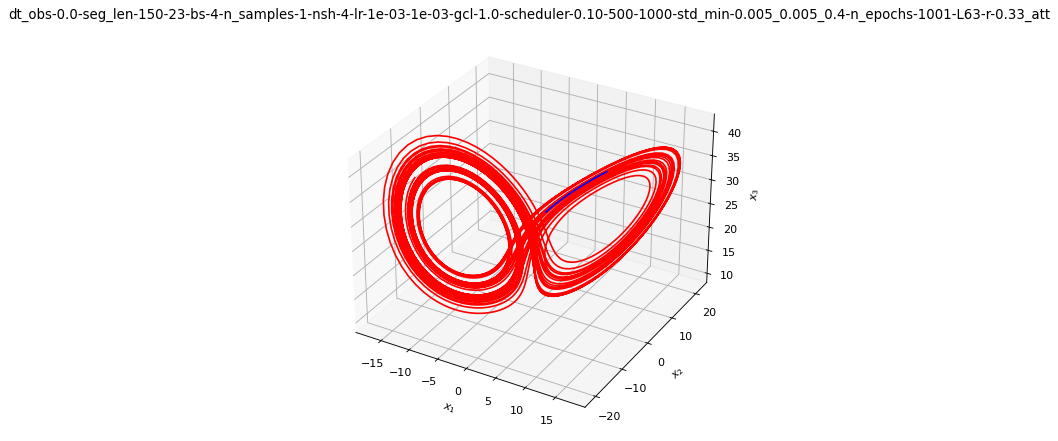

In [21]:
with torch.no_grad():
    x0 = torch.from_numpy(np.expand_dims((seqs_test[0,0,:]-v_mean)/v_std,axis=0)).to(device)
    gen_seq = daoden_utils.generate_seq(trans_model,x0,config.dt_integration,4000)
FIG_DPI = 80
fig=plt.figure(figsize=(1920/2/FIG_DPI, 1080/2/FIG_DPI), dpi=FIG_DPI)
daoden_utils.plot_attractor(gen_seq*v_std+v_mean,fig,title=config.filename,color='red')
daoden_utils.plot_attractor(gen_seq[:10]*v_std+v_mean,fig,title=config.filename,color='b')

#### Train DAODEN

In [22]:
def write_log(phase, epoch, best_epoch, model_name, elapsed_time,
              log_p = 0, log_prior = 0, log_q = 0, elbo = 0,
              std_p = 0, std_prior = 0, std_q = 0,
              trans_loss = 0, obs_loss = 0, total_loss = 0,
             ):
    if config.model_name in ["daoden_MAP","daoden_full"]:
        logging.info(phase + ", epoch: {0:d}, {1:d}".format(epoch, best_epoch)
                     +", log_p: {0:.2e}".format(log_p)
                     +", log_prior: {0:.2e}".format(log_prior)
                     +", log_q: {0:.2e}".format(log_q)
                     +", elbo: {0:.2e}".format(elbo)
                     +", std_p: {0:.2e}".format(std_p)
                     +", std_prior: {0:.2e}".format(std_prior)
                     +", std_q: {0:.2e}".format(std_q)
                     +", time per epoch: {0:.2f}s".format(elapsed_time))
    elif config.model_name == "daoden_determ":
        logging.info(phase + ", epoch: {0:d}, {1:d}".format(epoch, best_epoch)
                     +", trans_loss: {0:.2e}".format(trans_loss)
                     +", obs_loss: {0:.2e}".format(obs_loss)
                     +", total_loss: {0:.2e}".format(total_loss)
                     +", time per epoch: {0:.2f}s".format(elapsed_time))   

In [23]:
if config.retrain:
    l_losses = []
    d_best_epoch = 0
    d_best_loss  = 1e6
    for d_cur_epoch in range(d_epoch_begin,config.n_epochs):
        daoden_model.train()
        d_since = time.time()
        d_epoch_log_p = 0
        d_epoch_log_q = 0
        d_epoch_log_prior = 0
        d_epoch_loss = 0
        d_epoch_nums = 0
        d_epoch_trans_loss = 0
        d_epoch_obs_loss = 0

        for inputs, targets, masks, clean_targets in dl["train"]: 
            n_step_ahead = np.random.randint(1,config.n_step_ahead_max+1)
            opt.zero_grad()
            # Convert to time-major
            inputs  = inputs.to(device).permute(1,0,2)
            targets = targets.to(device).permute(1,0,2)
            masks = masks.type(torch.bool).to(device).permute(1,0,2)
            clean_targets = clean_targets.to(device).permute(1,0,2)    

            if config.model_name in ["daoden_MAP","daoden_full"]:
                mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, log_p_x_given_z,log_prior_z,log_q_z, neg_elbo \
                                        = daoden_model(inputs,targets,masks,clean_targets,n_step_ahead)
                neg_elbo.backward()

                d_epoch_log_p += log_p_x_given_z.item()*inputs.shape[1]
                d_epoch_log_q += log_q_z.item()*inputs.shape[1]
                d_epoch_log_prior += log_prior_z.item()*inputs.shape[1]
                d_epoch_loss += neg_elbo.item()*inputs.shape[1]
                d_epoch_nums += inputs.shape[1]

            elif config.model_name == "daoden_determ":
                mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, trans_loss, obs_loss \
                                        = daoden_model(inputs,targets,masks,clean_targets,n_step_ahead)   
                # Total loss
                total_loss = config.trans_w*trans_loss + config.obs_w*obs_loss
                total_loss.backward()

                d_epoch_trans_loss += trans_loss.item()*inputs.shape[1]
                d_epoch_obs_loss += obs_loss.item()*inputs.shape[1]
                d_epoch_loss += total_loss.item()*inputs.shape[1]
                d_epoch_nums += inputs.shape[1]

            ## Gradient clipping
            torch.nn.utils.clip_grad_value_(daoden_model.parameters(), config.grad_clipping_value)
            opt.step()

        if exp_lr_scheduler.last_epoch < config.scheduler_max_step:
            exp_lr_scheduler.step()

        d_elapsed_time = time.time()-d_since
        if d_cur_epoch%config.log_freq == 0:
            write_log("Train", d_cur_epoch+1, d_best_epoch, config.model_name, d_elapsed_time,
                      log_p = d_epoch_log_p/d_epoch_nums, 
                      log_prior = d_epoch_log_prior/d_epoch_nums, 
                      log_q = d_epoch_log_q/d_epoch_nums, 
                      elbo = -d_epoch_loss/d_epoch_nums,
                      std_p = torch.mean(torch.sqrt(var_p_seq)).item(),
                      std_prior = torch.mean(torch.sqrt(var_prior_seq)).item(), 
                      std_q = torch.mean(torch.sqrt(var_q_seq)).item(),
                      trans_loss = d_epoch_trans_loss/d_epoch_nums,
                      obs_loss = d_epoch_obs_loss/d_epoch_nums,
                      total_loss = d_epoch_loss/d_epoch_nums
                     )           

        ## SAVE AND EVALUATE
        #################################################
        if d_cur_epoch%config.save_freq == 0:
            torch.save(daoden_model.state_dict(), os.path.join(config.logdir,config.filename+"-"+str(d_cur_epoch+1)+".pt"))
            torch.save(opt.state_dict(), os.path.join(config.logdir,config.filename+"-opt"+"-"+str(d_cur_epoch+1)+".pt"))
            #np.save(os.path.join(config.logdir,config.filename+"-losses"+"-"+str(d_cur_epoch+1)),np.array(l_losses))
            d_since = time.time()
            daoden_model.eval()
            d_since = time.time()
            d_epoch_log_p = 0
            d_epoch_log_q = 0
            d_epoch_log_prior = 0
            d_epoch_loss = 0
            d_epoch_nums = 0
            d_epoch_trans_loss = 0
            d_epoch_obs_loss = 0
            
            with torch.no_grad():
                for inputs, targets, masks, clean_targets in dl["valid"]: 
                    n_step_ahead = 1
                    # Convert to time-major
                    inputs  = inputs.to(device).permute(1,0,2)
                    targets = targets.to(device).permute(1,0,2)
                    masks = masks.type(torch.bool).to(device).permute(1,0,2)
                    clean_targets = clean_targets.to(device).permute(1,0,2)                   
                    if config.model_name in ["daoden_MAP","daoden_full"]:
                        mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, log_p_x_given_z,log_prior_z,log_q_z, neg_elbo \
                                                = daoden_model(inputs,targets,masks,clean_targets,n_step_ahead)
                        d_epoch_log_p += log_p_x_given_z.item()*inputs.shape[1]
                        d_epoch_log_q += log_q_z.item()*inputs.shape[1]
                        d_epoch_log_prior += log_prior_z.item()*inputs.shape[1]
                        d_epoch_loss += neg_elbo.item()*inputs.shape[1]
                        d_epoch_nums += inputs.shape[1]
                    elif config.model_name == "daoden_determ":
                        mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, trans_loss, obs_loss \
                                                 = daoden_model(inputs,targets,masks,clean_targets,n_step_ahead) 
                        total_loss = config.trans_w*trans_loss + config.obs_w*obs_loss
                        d_epoch_trans_loss += trans_loss.item()*inputs.shape[1]
                        d_epoch_obs_loss += obs_loss.item()*inputs.shape[1]
                        d_epoch_loss += total_loss.item()*inputs.shape[1]
                        d_epoch_nums += inputs.shape[1]
                    x0 = torch.from_numpy(np.expand_dims((seqs_test[0,0]-v_mean)/v_std,axis=0)).to(device)
                    gen_seq = daoden_utils.generate_seq(trans_model,x0,config.dt_integration,2000)
            d_elapsed_time = time.time()-d_since
            if d_epoch_loss < d_best_loss:
                d_best_loss  = d_epoch_loss
                d_best_epoch = d_cur_epoch+1 
            write_log("Evaluation", d_cur_epoch+1, d_best_epoch, config.model_name, d_elapsed_time,
                      log_p = d_epoch_log_p/d_epoch_nums, 
                      log_prior = d_epoch_log_prior/d_epoch_nums, 
                      log_q = d_epoch_log_q/d_epoch_nums, 
                      elbo = -d_epoch_loss/d_epoch_nums,
                      std_p = torch.mean(torch.sqrt(var_p_seq)).item(),
                      std_prior = torch.mean(torch.sqrt(var_prior_seq)).item(), 
                      std_q = torch.mean(torch.sqrt(var_q_seq)).item(),
                      trans_loss = d_epoch_trans_loss/d_epoch_nums,
                      obs_loss = d_epoch_obs_loss/d_epoch_nums,
                      total_loss = d_epoch_loss/d_epoch_nums
                     )             
            
            ## Plot a generated attractor.
            FIG_DPI = 80
            fig=plt.figure(figsize=(1920/2/FIG_DPI, 1080/2/FIG_DPI), dpi=FIG_DPI)
            daoden_utils.plot_attractor(gen_seq*v_std+v_mean,fig,title=config.filename,color='red')
            daoden_utils.plot_attractor(gen_seq[:10]*v_std+v_mean,fig,title=config.filename,color='b')
            plt.savefig(os.path.join(config.logdir,config.filename+"-"+str(d_cur_epoch+1)+".png"), dpi=FIG_DPI)
            plt.close()

            ## Plot the training states.
            FIG_DPI = 80
            corlor = ['r','g','b']
            plt.figure(figsize=(1920/2/FIG_DPI, 1080*2/2/FIG_DPI), dpi=FIG_DPI)
            for d_i in range(0,3):
                x_q_lb_seq     = (mu_q_seq - torch.sqrt(var_q_seq)).detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i]
                x_q_ub_seq     = (mu_q_seq + torch.sqrt(var_q_seq)).detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i]
                x_prior_lb_seq = (mu_prior_seq - torch.sqrt(var_prior_seq)).detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i]
                x_prior_ub_seq = (mu_prior_seq + torch.sqrt(var_prior_seq)).detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i]
                x_p_lb_seq     = (mu_q_seq - torch.sqrt(var_p_seq)).detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i]
                x_p_ub_seq     = (mu_q_seq + torch.sqrt(var_p_seq)).detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i]

                plt.subplot(3,1,d_i+1)
                if config.init_seg_len == 0:
                    plt.plot(targets[n_step_ahead:,0,d_i].detach().numpy()*v_std[d_i]+v_mean[d_i],'ko')
                else:
                    plt.plot(targets[(config.init_seg_len+n_step_ahead):-config.init_seg_len,0,d_i].detach().numpy()*v_std[d_i]+v_mean[d_i],'ko')

                plt.plot(clean_targets[(config.init_seg_len+n_step_ahead):-config.init_seg_len,0,d_i].detach().numpy()*v_std[d_i]+v_mean[d_i],'r')
                plt.plot(mu_q_seq.detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i],'b--')
                plt.plot(mu_prior_seq.detach().numpy()[n_step_ahead:,0,d_i]*v_std[d_i]+v_mean[d_i],'g--')
                v_x_axis = np.arange(x_prior_lb_seq.shape[0])
                l_lengends = ["Observations","True_sequence","q_sequence","prior_sequence"]
                if config.model_name == "daoden_MAP":
                    plt.fill_between(v_x_axis,x_prior_lb_seq,x_prior_ub_seq,facecolor='green', alpha=0.2)
                    plt.fill_between(v_x_axis,x_p_lb_seq,x_p_ub_seq,facecolor='red', alpha=0.2)
                    l_lengends += ["prior_std","emission_std"]
                elif config.model_name == "daoden_full":
                    plt.fill_between(v_x_axis,x_prior_lb_seq,x_prior_ub_seq,facecolor='green', alpha=0.2)
                    plt.fill_between(v_x_axis,x_p_lb_seq,x_p_ub_seq,facecolor='red', alpha=0.2)
                    plt.fill_between(v_x_axis,x_q_lb_seq,x_q_ub_seq,facecolor='blue', alpha=0.2)
                    l_lengends += ["prior_std","emission_std","q_std"]
                plt.legend(l_lengends)

                plt.title("Sequence_x%d, n_step_ahead: %d"%(d_i,n_step_ahead))
            plt.savefig(os.path.join(config.logdir,config.filename+"-"+str(d_cur_epoch+1)+"-sequence.png"), dpi=FIG_DPI)
            plt.close()


In [24]:
print("Trained epoch: ",d_cur_epoch)

Trained epoch:  1001


## Validation

### Simulation

In [25]:
with torch.no_grad():
    x0 = torch.from_numpy(np.expand_dims((seqs_test[0,0]-v_mean)/v_std,axis=0)).to(device)
    gen_seq = daoden_utils.generate_seq(trans_model,x0,config.dt_integration,4000)

Plot attractor and sequences

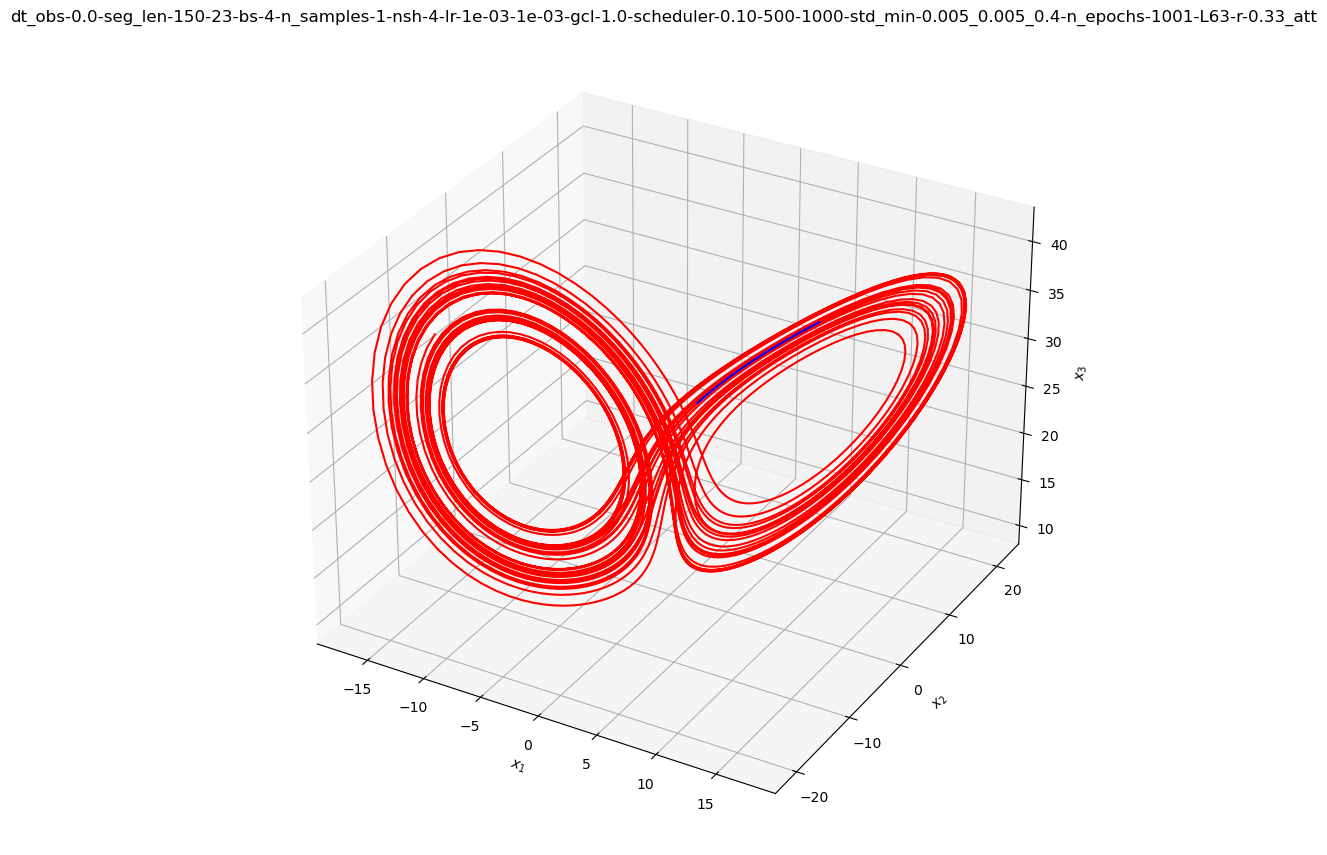

In [26]:
FIG_DPI = 100
fig=plt.figure(figsize=(1920/FIG_DPI, 1080/FIG_DPI), dpi=FIG_DPI)
daoden_utils.plot_attractor(gen_seq*v_std+v_mean,fig,title="",color='red')
plt.savefig(config.savedir+config.filename+"-"+str(d_cur_epoch)+".pdf", dpi=FIG_DPI)
daoden_utils.plot_attractor(gen_seq[:10]*v_std+v_mean,fig,title=config.filename,color='b')
plt.savefig(config.savedir+config.filename+"-"+str(d_cur_epoch)+".png", dpi=FIG_DPI)

In [27]:
if config.model_name in ["daoden_MAP","daoden_full"]:
    manual_seed = 58
    torch.manual_seed(manual_seed)
    with torch.no_grad():
        x0 = torch.from_numpy(np.expand_dims((seqs_test[0,0]-v_mean)/v_std,axis=0)).to(device)
        state_seq,var_seq = daoden_utils.generate_seq_stoch(daoden_model,x0,config.dt_integration,4000)

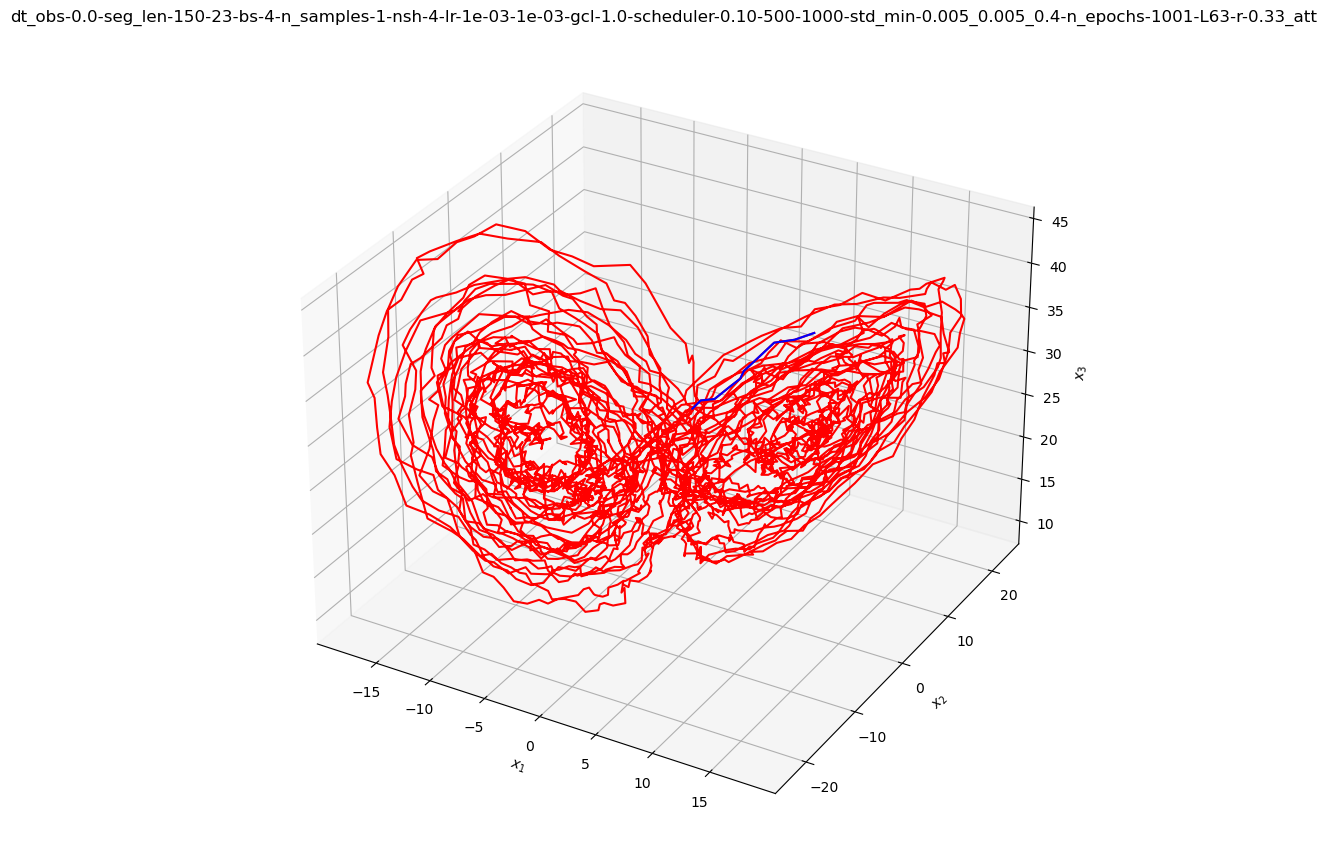

In [28]:
if config.model_name in ["daoden_MAP","daoden_full"]:
    FIG_DPI = 100
    fig=plt.figure(figsize=(1920/FIG_DPI, 1080/FIG_DPI), dpi=FIG_DPI)
    daoden_utils.plot_attractor(state_seq*v_std+v_mean,fig,title="",color='red')
    plt.savefig(config.savedir+config.filename+"-"+str(d_cur_epoch)+"-seed-"+str(manual_seed)+"_stoch.pdf", dpi=FIG_DPI)
    daoden_utils.plot_attractor(state_seq[:10]*v_std+v_mean,fig,title=config.filename,color='b')
    plt.savefig(config.savedir+config.filename+"-"+str(d_cur_epoch)+"-seed-"+str(manual_seed)+"_stoch.png", dpi=FIG_DPI)

### Quantitative evaluation

#### Lyapunov exponent

In [29]:
seqs_test.shape

(50, 1000, 3)

100%|██████████| 20000/20000 [03:22<00:00, 98.84it/s] 


l1000:  0.9031112493248679 0.14551219745345034
l20000: 0.846 ± 0.012


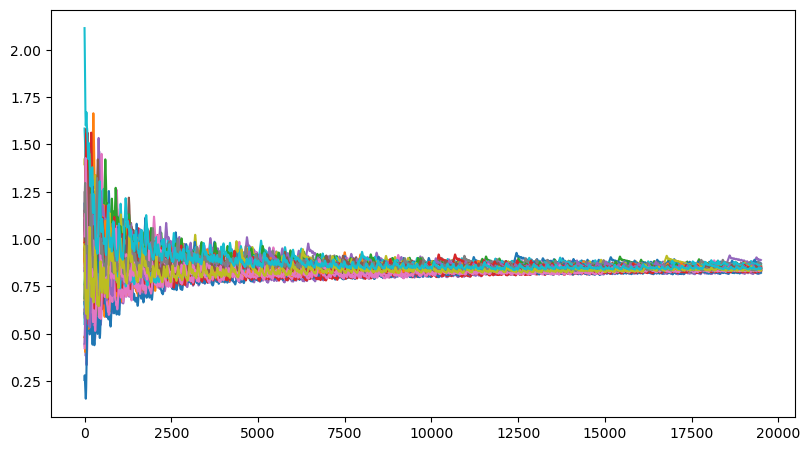

In [30]:
x0 = seqs_test[:,0,:].astype(np.float32) #(n_ics_test,data_dim)
#x0 = seqs_train[:50,24,:].astype(np.float32) #(n_ics_test,data_dim)
n_ics_test,data_dim = x0.shape
N_lyapunov = 20000
lyap_exp,pred_series = daoden_utils.compute_largest_lyap(trans_model,x0,config.dt_integration,1E-2,N_lyapunov,v_mean,v_std)
fig=plt.figure(figsize=(1920/2/FIG_DPI, 1080/2/FIG_DPI), dpi=FIG_DPI)
plt.plot(lyap_exp[500:])
print("l1000: ",np.mean(lyap_exp[1000]),np.std(lyap_exp[1000])) #l 1
print("l{0:d}: {1:.3f}".format(N_lyapunov,np.mean(lyap_exp[-1])),u"\u00B1","{0:.3f}".format(np.std(lyap_exp[-1]))) #l 1

#### Short-term forecasting

In [31]:
gen_seqs = np.swapaxes(pred_series,0,1)
print(gen_seqs.shape)
print(pred_series.shape)

(50, 20000, 3)
(20000, 50, 3)


In [32]:
def RMSE(a,b):
    """ Compute the Root Mean Square Error between 2 n-dimensional vectors. """
    return np.sqrt(np.mean((a-b)**2))
v_e1, v_e4 = np.zeros(n_ics_test),np.zeros(n_ics_test)
for d_idx in range(n_ics_test):
    v_e1[d_idx] = RMSE(gen_seqs[d_idx,0,:],seqs_test[d_idx,1,:])
    v_e4[d_idx] = RMSE(gen_seqs[d_idx,:3+1,:],seqs_test[d_idx,1:4+1,:])
print("e1: {0:.3f}".format(np.mean(v_e1)),u"\u00B1","{0:.3f}".format(np.std(v_e1)))
print("e4: {0:.3f}".format(np.mean(v_e4)),u"\u00B1","{0:.3f}".format(np.std(v_e4)))

e1: 0.065 ± 0.044
e4: 0.164 ± 0.105


In [33]:
seqs_test.shape

(50, 1000, 3)

In [34]:
def AnDA_RMSE(a,b):
    """ Compute the Root Mean Square Error between 2 n-dimensional vectors. """
    return np.sqrt(np.mean((a-b)**2))
n_ics_test, seq_len_test, _ = seqs_test.shape
m_e = np.zeros((n_ics_test,seq_len_test-1)).astype(np.float32)
for d_idx_ic in range(n_ics_test):
    for d_idx_t in range(seq_len_test-1):
        m_e[d_idx_ic,d_idx_t] = AnDA_RMSE(gen_seqs[d_idx_ic,:d_idx_t+1,:],seqs_test[d_idx_ic,1:d_idx_t+2,:])
# print("e1: {0:.3f}".format(np.mean(v_e1)),u"\u00B1","{0:.3f}".format(np.std(v_e1)))
# print("e4: {0:.3f}".format(np.mean(v_e4)),u"\u00B1","{0:.3f}".format(np.std(v_e4)))

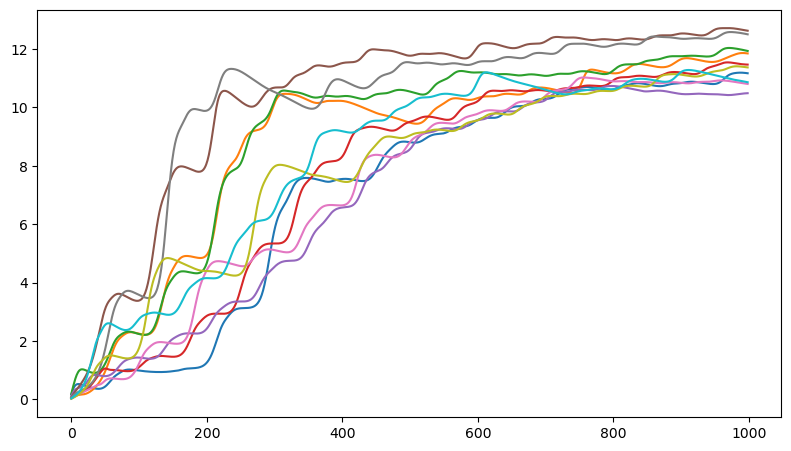

In [35]:
fig=plt.figure(figsize=(1920/2/FIG_DPI, 1080/2/FIG_DPI), dpi=FIG_DPI)
for i in range(10):
  plt.plot(m_e[i,:])

In [36]:
v_pi_half = np.zeros(n_ics_test)
lamda1 = 0.91
for d_idx_ic in range(n_ics_test):
  v_pi_half[d_idx_ic] = np.where(m_e[d_idx_ic,:]>0.5*np.mean(v_std))[0][0]*lamda1*config.dt_integration

In [37]:
v_pi_half

array([2.6208, 1.3286, 1.3923, 2.3296, 2.6208, 1.0556, 1.7836, 1.2012,
       1.1284, 2.0202, 1.7381, 3.7219, 1.7472, 3.6218, 1.2558, 1.4378,
       0.4732, 2.2659, 4.095 , 1.1739, 1.1466, 2.8028, 1.6835, 3.6218,
       2.0384, 2.4752, 1.7108, 1.4378, 2.8119, 1.9747, 1.5561, 0.7098,
       0.455 , 1.5561, 1.3104, 1.1193, 4.1769, 1.911 , 0.7644, 3.2669,
       1.1011, 0.4823, 2.1749, 0.4459, 2.7482, 1.0738, 1.7472, 3.1031,
       2.7118, 1.7017])

In [38]:
print(config.filename)
print("e1: {0:.3f}".format(np.mean(v_e1)),u"\u00B1","{0:.3f}".format(np.std(v_e1)))
print("e4: {0:.3f}".format(np.mean(v_e4)),u"\u00B1","{0:.3f}".format(np.std(v_e4)))
print("pi1/2: {0:.3f}".format(np.mean(v_pi_half)),u"\u00B1","{0:.3f}".format(np.std(v_pi_half)))
print("l{0:d}: {1:.3f}".format(N_lyapunov,np.mean(lyap_exp[-1])),u"\u00B1","{0:.3f}".format(np.std(lyap_exp[-1]))) #l 1

dt_obs-0.0-seg_len-150-23-bs-4-n_samples-1-nsh-4-lr-1e-03-1e-03-gcl-1.0-scheduler-0.10-500-1000-std_min-0.005_0.005_0.4-n_epochs-1001-L63-r-0.33_att
e1: 0.065 ± 0.044
e4: 0.164 ± 0.105
pi1/2: 1.897 ± 0.953
l20000: 0.846 ± 0.012


#### Assimilation

In [39]:
# daoden_model.model_name = "daoden_MAP"
daoden_model.n_samples = 50

In [40]:
# tmp = inputs.repeat(())

In [41]:
d_since = time.time()
daoden_model.eval()
d_since = time.time()
d_epoch_log_p = 0
d_epoch_log_q = 0
d_epoch_log_prior = 0
d_epoch_loss = 0
d_epoch_nums = 0
d_epoch_trans_loss = 0
d_epoch_obs_loss = 0

with torch.no_grad():
    for inputs, targets, masks, clean_targets in dl["test"]: 
        n_step_ahead = 1
        # Convert to time-major
        inputs  = inputs.to(device).permute(1,0,2)[:config.segment_len]
        targets = targets.to(device).permute(1,0,2)[:config.segment_len]
        masks = masks.type(torch.bool).to(device).permute(1,0,2)[:config.segment_len]
        clean_targets = clean_targets.to(device).permute(1,0,2)[:config.segment_len]                  
        if config.model_name in ["daoden_MAP","daoden_full"]:
            mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, log_p_x_given_z,log_prior_z,log_q_z, neg_elbo \
                                    = daoden_model(inputs,targets,masks,clean_targets,n_step_ahead)
            d_epoch_log_p += log_p_x_given_z.item()*inputs.shape[1]
            d_epoch_log_q += log_q_z.item()*inputs.shape[1]
            d_epoch_log_prior += log_prior_z.item()*inputs.shape[1]
            d_epoch_loss += neg_elbo.item()*inputs.shape[1]
            d_epoch_nums += inputs.shape[1]
        elif config.model_name == "daoden_determ":
            mu_q_seq, var_q_seq, mu_prior_seq, var_prior_seq, var_p_seq, trans_loss, obs_loss \
                                      = daoden_model(inputs,targets,masks,clean_targets,n_step_ahead) 
            total_loss = config.trans_w*trans_loss + config.obs_w*obs_loss
            d_epoch_trans_loss += trans_loss.item()*inputs.shape[1]
            d_epoch_obs_loss += obs_loss.item()*inputs.shape[1]
            d_epoch_loss += total_loss.item()*inputs.shape[1]
            d_epoch_nums += inputs.shape[1]
d_elapsed_time = time.time()-d_since 
write_log("Test", d_cur_epoch+1, -1, config.model_name, d_elapsed_time,
          log_p = d_epoch_log_p/d_epoch_nums, 
          log_prior = d_epoch_log_prior/d_epoch_nums, 
          log_q = d_epoch_log_q/d_epoch_nums, 
          elbo = -d_epoch_loss/d_epoch_nums,
          std_p = torch.mean(torch.sqrt(var_p_seq)).item(),
          std_prior = torch.mean(torch.sqrt(var_prior_seq)).item(), 
          std_q = torch.mean(torch.sqrt(var_q_seq)).item(),
          trans_loss = d_epoch_trans_loss/d_epoch_nums,
          obs_loss = d_epoch_obs_loss/d_epoch_nums,
          total_loss = d_epoch_loss/d_epoch_nums
          ) 

2020-09-08 18:30:22,278 - root - Test, epoch: 1002, -1, log_p: -1.13e-01, log_prior: 4.19e+00, log_q: 4.33e+00, elbo: -4.23e-01, std_p: 3.96e-01, std_prior: 5.84e-02, std_q: 5.54e-02, time per epoch: 1.92s


Recontructed sequence and groundtruth

In [42]:
reconstructed_seqs = np.swapaxes(mu_q_seq.detach().numpy(),0,1)*v_std + v_mean
print(reconstructed_seqs.shape)
gt_seqs = seqs_test[:,config.init_seg_len:(config.segment_len-config.init_seg_len),:]
print(gt_seqs.shape)

(50, 104, 3)
(50, 104, 3)


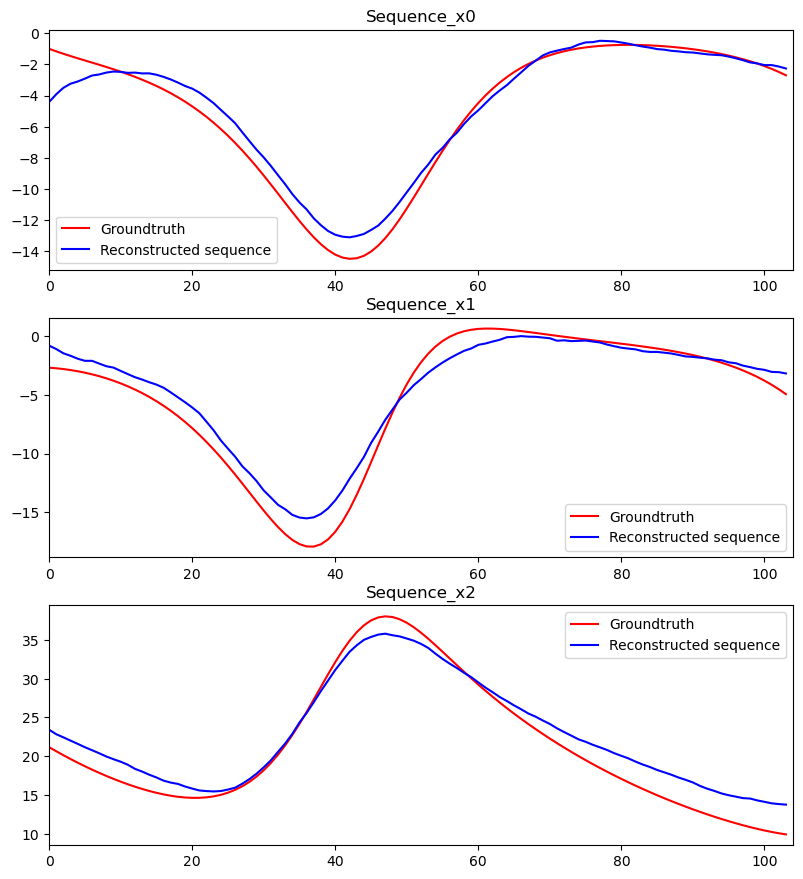

In [43]:
FIG_DPI = 100
plt.figure(figsize=(1920/2/FIG_DPI, 1080*2/2/FIG_DPI), dpi=FIG_DPI)
for d_i in range(0,3):
    plt.subplot(3,1,d_i+1)
    plt.plot(gt_seqs[0,:,d_i],'r')
    plt.plot(reconstructed_seqs[0,:,d_i],'b')
    plt.title("Sequence_x%d"%(d_i))
    plt.legend(["Groundtruth","Reconstructed sequence"])
    plt.xlim([0,gt_seqs.shape[1]])
plt.savefig(config.savedir+config.filename+"-"+str(d_cur_epoch)+"_assimilation.png", dpi=FIG_DPI)

In [44]:
v_a_e = np.zeros(n_ics_test)
for d_idx in range(n_ics_test):
    v_a_e[d_idx] = RMSE(gt_seqs[d_idx,:,:],reconstructed_seqs[d_idx,:,:])
print("RMSE-a: {0:.3f}".format(np.mean(v_a_e))+u"\u00B1"+"{0:.3f}\n".format(np.std(v_a_e)))

RMSE-a: 1.687±0.929



#### Write to disk

In [45]:
with open(config.savedir+config.filename+"-"+str(d_cur_epoch)+"-results.txt", "a") as f:
    f.write("#=========================================\n")
    f.write("e1: {0:.3f}".format(np.mean(v_e1))+u"\u00B1"+"{0:.3f}\n".format(np.std(v_e1)))
    f.write("e4: {0:.3f}".format(np.mean(v_e4))+u"\u00B1"+"{0:.3f}\n".format(np.std(v_e4)))
    f.write("RMSE-a: {0:.3f}".format(np.mean(v_a_e))+u"\u00B1"+"{0:.3f}\n".format(np.std(v_a_e)))
    f.write("pi1/2: {0:.3f}".format(np.mean(v_pi_half))+u"\u00B1"+"{0:.3f}\n".format(np.std(v_pi_half)))
    f.write("l{0:d}: {1:.3f}".format(N_lyapunov,np.mean(lyap_exp[-1]))+u"\u00B1"+"{0:.3f}\n".format(np.std(lyap_exp[-1]))) #l 1